In [12]:
import os
import requests

def save_and_cache(url, path, force=False):
    if not os.path.exists(path) or force:
        print(f"Downloading {url} to {path} ...")
        r = requests.get(url)
        with open(path, 'wb') as f:
            f.write(r.content)

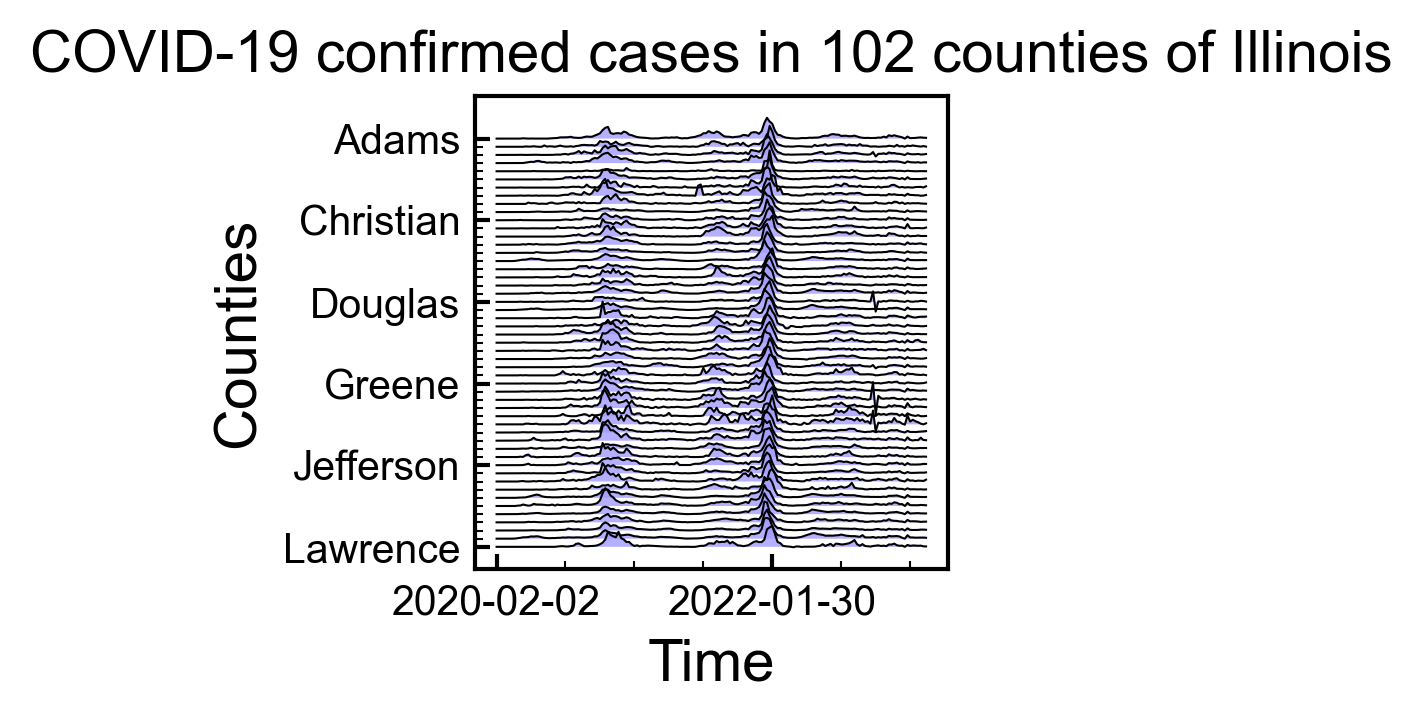

(102,) (163,) (163, 102)


2020-01-26  2020-02-02  2020-02-09  2020-02-16  2020-02-23  \
Admin2                                                                   
Adams                0           0           0           0           0   
Alexander            0           0           0           0           0   
Bond                 0           0           0           0           0   
Boone                0           0           0           0           0   
Brown                0           0           0           0           0   
...                ...         ...         ...         ...         ...   
Whiteside            0           0           0           0           0   
Will                 0           0           0           0           0   
Williamson           0           0           0           0           0   
Winnebago            0           0           0           0           0   
Woodford             0           0           0           0           0   

            2020-03-01  2020-03-08  2020-03-15  2020-03-22  2020-03-29  ...  \
Admin2                                                                  ...   
Adams                0           0           0           1           2  ...   
Alexander            0           0           0           0           0  ...   
Bond                 0           0           0           0           1  ...   
Boone                0           0           0           0           0  ...   
Brown                0           0           0           0           0  ...   
...                ...         ...         ...         ...         ...  ...   
Whiteside            0           0           0           1           3  ...   
Will                 0           0           0          21         182  ...   
Williamson           0           0           0           1           1  ...   
Winnebago            0           0           0           4          12  ...   
Woodford             0           0           1           2           4  ...   

            2023-01-08  2023-01-15  2023-01-22  2023-01-29  2023-02-05  \
Admin2                                                                   
Adams            27445       27445       27585       27617       27656   
Alexander         1541        1541        1548        1552        1560   
Bond              5206        5204        5231        5244        5254   
Boone            17238       17238       17318       17361       17395   
Brown             2831        2831        2849        2857        2862   
...                ...         ...         ...         ...         ...   
Whiteside        19147       19147       19235       19271       19302   
Will            211140      211140      212868      213476      214045   
Williamson       28257       28257       28439       28527       28600   
Winnebago        98681       98681       99254       99485       99691   
Woodford         12363       12363       12413       12444       12472   

            2023-02-12  2023-02-19  2023-02-26  2023-03-05  2023-03-12  
Admin2                                                                  
Adams            27703       27773       27857       27919       27974  
Alexander         1565        1568        1569        1573        1574  
Bond              5265        5280        5287        5295        5310  
Boone            17423       17466       17482       17517       17550  
Brown             2862        2865        2869        2871        2873  
...                ...         ...         ...         ...         ...  
Whiteside        19346       19377       19414       19472       19530  
Will            214681      215354      215914      216442      216951  
Williamson       28661       28740       28813       28892       28971  
Winnebago        99873      100056      100231      100463      100711  
Woodford         12509       12527       12578       12611       12654  

[102 rows x 164 columns]

In [13]:
import numpy as np
import pandas as pd

save_and_cache('https://ghp.ci/https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv', '../data/epidemic/time_series_covid19_confirmed_US.csv')
df_US = pd.read_csv('../data/epidemic/time_series_covid19_confirmed_US.csv')
df_IL = df_US[df_US['Province_State'] == 'Illinois'].copy()
df_IL = df_IL[df_IL['Admin2'] != 'Unassigned']
df_IL = df_IL[df_IL['Admin2'] != 'Out of IL']
df_IL.drop(columns=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Province_State', 'Country_Region', 'Lat', 'Long_', 'Combined_Key'], inplace=True)
assert len(df_IL['Admin2'].unique()) == len(df_IL['Admin2'])
df_IL.set_index('Admin2', inplace=True)
# df_IL.rename(index={'Cook': 'Chicago'}, inplace=True)
df_IL.sort_index(inplace=True)

# 等间隔为 1 日
assert len(pd.to_datetime(df_IL.columns.values, format='%m/%d/%y').diff()[1:].unique()) == 1
# 汇总为 1 周的数据
df_IL.columns = pd.to_datetime(df_IL.columns, format='%m/%d/%y')
df_IL = df_IL.T.resample('W').max().T # 这里是累计确诊数，所以取最大值作为本周累计确诊数

node = df_IL.index.to_numpy() # (N,)
time = pd.to_datetime(df_IL.columns.values, format='%m/%d/%y').astype(str).values[1:] # (T,)
case = np.diff(df_IL.values.T, axis=0) # (T, N)

import matplotlib.pyplot as plt
from ND2.utils import get_fig, clear_svg
fi, fig, axes = get_fig(1, 1, AW=4, AH=4, lw=1.0, fontsize=14)

N = 51
dN = 10
dT = 52 * 2
delta = -1
for idx, name in enumerate(node[:N]):
    scale = N / 20 / case[:, idx].max()
    axes[0].plot(case[:, idx] * scale + delta*idx, color='black', lw=fi.lw/2)
    axes[0].fill_between(np.arange(len(time)), case[:, idx] * scale + delta*idx, delta*idx, color='#a29bfe', alpha=0.8, edgecolor=None)
axes[0].set_xticks(np.arange(len(time))[::dT])
axes[0].set_xticks(np.arange(len(time))[::dT//4], minor=True)
axes[0].set_xticklabels(time[::dT], rotation=0, fontsize=0.7*fi.fontsize)
axes[0].set_xlabel('Time', fontsize=fi.fontsize)

axes[0].set_yticks(delta*np.arange(len(node))[:N:dN])
axes[0].set_yticks(delta*np.arange(len(node))[:N], minor=True)
axes[0].tick_params(axis='both', which='minor', width=fi.lw/2)
axes[0].set_yticklabels(node[:N:dN], fontsize=0.7*fi.fontsize)
# axes[0].set_yticklabels([], fontsize=fi.fontsize)
axes[0].set_ylabel('Counties', fontsize=fi.fontsize)

axes[0].tick_params(axis='both', which='both', direction='in')
axes[0].set_title(f'COVID-19 confirmed cases in {len(node)} counties of Illinois', fontsize=fi.fontsize)
fig.savefig('../plot/epidemic/COVID19inILS.png', dpi=300, transparent=True)
fig.savefig('../plot/epidemic/COVID19inILS.svg', transparent=True)
clear_svg('../plot/epidemic/COVID19inILS.svg')
plt.show()

print(node.shape, time.shape, case.shape)

df_IL

In [14]:
node

array(['Adams', 'Alexander', 'Bond', 'Boone', 'Brown', 'Bureau',
       'Calhoun', 'Carroll', 'Cass', 'Champaign', 'Christian', 'Clark',
       'Clay', 'Clinton', 'Coles', 'Cook', 'Crawford', 'Cumberland',
       'De Witt', 'DeKalb', 'Douglas', 'DuPage', 'Edgar', 'Edwards',
       'Effingham', 'Fayette', 'Ford', 'Franklin', 'Fulton', 'Gallatin',
       'Greene', 'Grundy', 'Hamilton', 'Hancock', 'Hardin', 'Henderson',
       'Henry', 'Iroquois', 'Jackson', 'Jasper', 'Jefferson', 'Jersey',
       'Jo Daviess', 'Johnson', 'Kane', 'Kankakee', 'Kendall', 'Knox',
       'LaSalle', 'Lake', 'Lawrence', 'Lee', 'Livingston', 'Logan',
       'Macon', 'Macoupin', 'Madison', 'Marion', 'Marshall', 'Mason',
       'Massac', 'McDonough', 'McHenry', 'McLean', 'Menard', 'Mercer',
       'Monroe', 'Montgomery', 'Morgan', 'Moultrie', 'Ogle', 'Peoria',
       'Perry', 'Piatt', 'Pike', 'Pope', 'Pulaski', 'Putnam', 'Randolph',
       'Richland', 'Rock Island', 'Saline', 'Sangamon', 'Schuyler',
       'Scott'

In [15]:
len(node)

102

# 移动数据

In [16]:
import pandas as pd

# see https://tbed.org/demo/index.php?tablename=state&function=details&items_table_name=county_vw&where_field=state_code&where_value=17&order=state_code&order_type=ASC&store_session_table_infos_for_items_table=1&page=1
GEOID2Name = {17001: "Adams", 17003: "Alexander", 17005: "Bond", 17007: "Boone", 17009: "Brown", 17011: "Bureau", 17013: "Calhoun", 17015: "Carroll", 17017: "Cass", 17019: "Champaign", 17021: "Christian", 17023: "Clark", 17025: "Clay", 17027: "Clinton", 17029: "Coles", 17031: "Cook", 17033: "Crawford", 17035: "Cumberland", 17037: "DeKalb", 17039: "De Witt", 17041: "Douglas", 17043: "DuPage", 17045: "Edgar", 17047: "Edwards", 17049: "Effingham", 17051: "Fayette", 17053: "Ford", 17055: "Franklin", 17057: "Fulton", 17059: "Gallatin", 17061: "Greene", 17063: "Grundy", 17065: "Hamilton", 17067: "Hancock", 17069: "Hardin", 17071: "Henderson", 17073: "Henry", 17075: "Iroquois", 17077: "Jackson", 17079: "Jasper", 17081: "Jefferson", 17083: "Jersey", 17085: "Jo Daviess", 17087: "Johnson", 17089: "Kane", 17091: "Kankakee", 17093: "Kendall", 17095: "Knox", 17097: "Lake", 17099: "LaSalle", 17101: "Lawrence", 17103: "Lee", 17105: "Livingston", 17107: "Logan", 17109: "McDonough", 17111: "McHenry", 17113: "McLean", 17115: "Macon", 17117: "Macoupin", 17119: "Madison", 17121: "Marion", 17123: "Marshall", 17125: "Mason", 17127: "Massac", 17129: "Menard", 17131: "Mercer", 17133: "Monroe", 17135: "Montgomery", 17137: "Morgan", 17139: "Moultrie", 17141: "Ogle", 17143: "Peoria", 17145: "Perry", 17147: "Piatt", 17149: "Pike", 17151: "Pope", 17153: "Pulaski", 17155: "Putnam", 17157: "Randolph", 17159: "Richland", 17161: "Rock Island", 17163: "St. Clair", 17165: "Saline", 17167: "Sangamon", 17169: "Schuyler", 17171: "Scott", 17173: "Shelby", 17175: "Stark", 17177: "Stephenson", 17179: "Tazewell", 17181: "Union", 17183: "Vermilion", 17185: "Wabash", 17187: "Warren", 17189: "Washington", 17191: "Wayne", 17193: "White", 17195: "Whiteside", 17197: "Will", 17199: "Williamson", 17201: "Winnebago", 17203: "Woodford"}

# https://lehd.ces.census.gov/data/ 提供的 OD 数据，参考 https://lehd.ces.census.gov/data/lodes/LODES8/LODESTechDoc8.1.pdf
save_and_cache('https://lehd.ces.census.gov/data/lodes/LODES8/il/od/il_od_main_JT00_2020.csv.gz',
                '../data/epidemic/il_od_main_JT00_2020.csv.gz')
df = pd.read_csv('../data/epidemic/il_od_main_JT00_2020.csv.gz', compression='gzip')
# 15-digits BLOCK CODE (state(2), county(3), tract(6), block(4)) -> 5-digits COUNTY CODE
df['w_county'] = df['w_geocode'].astype(str).str.slice(0, 5).astype(int).map(GEOID2Name)
df['h_county'] = df['h_geocode'].astype(str).str.slice(0, 5).astype(int).map(GEOID2Name)

df

w_geocode        h_geocode  S000  SA01  SA02  SA03  SE01  SE02  \
0        170010001001000  170679538002027     1     0     1     0     1     0   
1        170010001001001  170010001002005     1     0     0     1     0     0   
2        170010001001001  170010002011025     1     0     1     0     0     1   
3        170010001001001  170010007002002     1     0     1     0     0     0   
4        170010001001001  170010010022000     1     1     0     0     0     1   
...                  ...              ...   ...   ...   ...   ...   ...   ...   
4894362  172030307003211  171479545003087     1     0     1     0     1     0   
4894363  172030307003211  172030307003077     1     0     0     1     0     1   
4894364  172030307003217  171130005043020     1     0     0     1     0     1   
4894365  172030307003217  172030307002041     1     0     0     1     0     1   
4894366  172030307003217  172030307003212     1     0     0     1     0     1   

         SE03  SI01  SI02  SI03  createdate  w_county  h_county  
0           0     1     0     0    20230321     Adams   Hancock  
1           1     0     0     1    20230321     Adams     Adams  
2           0     0     0     1    20230321     Adams     Adams  
3           1     0     0     1    20230321     Adams     Adams  
4           0     0     0     1    20230321     Adams     Adams  
...       ...   ...   ...   ...         ...       ...       ...  
4894362     0     0     1     0    20230321  Woodford     Piatt  
4894363     0     0     1     0    20230321  Woodford  Woodford  
4894364     0     1     0     0    20230321  Woodford    McLean  
4894365     0     1     0     0    20230321  Woodford  Woodford  
4894366     0     1     0     0    20230321  Woodford  Woodford  

[4894367 rows x 15 columns]

In [17]:
df.dropna(subset=['w_county', 'h_county'], inplace=True)
df

w_geocode        h_geocode  S000  SA01  SA02  SA03  SE01  SE02  \
0        170010001001000  170679538002027     1     0     1     0     1     0   
1        170010001001001  170010001002005     1     0     0     1     0     0   
2        170010001001001  170010002011025     1     0     1     0     0     1   
3        170010001001001  170010007002002     1     0     1     0     0     0   
4        170010001001001  170010010022000     1     1     0     0     0     1   
...                  ...              ...   ...   ...   ...   ...   ...   ...   
4894362  172030307003211  171479545003087     1     0     1     0     1     0   
4894363  172030307003211  172030307003077     1     0     0     1     0     1   
4894364  172030307003217  171130005043020     1     0     0     1     0     1   
4894365  172030307003217  172030307002041     1     0     0     1     0     1   
4894366  172030307003217  172030307003212     1     0     0     1     0     1   

         SE03  SI01  SI02  SI03  createdate  w_county  h_county  
0           0     1     0     0    20230321     Adams   Hancock  
1           1     0     0     1    20230321     Adams     Adams  
2           0     0     0     1    20230321     Adams     Adams  
3           1     0     0     1    20230321     Adams     Adams  
4           0     0     0     1    20230321     Adams     Adams  
...       ...   ...   ...   ...         ...       ...       ...  
4894362     0     0     1     0    20230321  Woodford     Piatt  
4894363     0     0     1     0    20230321  Woodford  Woodford  
4894364     0     1     0     0    20230321  Woodford    McLean  
4894365     0     1     0     0    20230321  Woodford  Woodford  
4894366     0     1     0     0    20230321  Woodford  Woodford  

[4894367 rows x 15 columns]

In [18]:
df = df[['w_county', 'h_county', 'S000']]
df.columns = ['source', 'destination', 'flow']
# 汇总
df = df.groupby(['source', 'destination']).sum().reset_index()
# 排除自己到自己的流量
df = df[df['source'] != df['destination']]
# 排除不在 node 中的记录
df = df[df['source'].isin(node) & df['destination'].isin(node)]
# assert all(np.sort(df['source'].unique()) == np.sort(df['destination'].unique()))
for i in node: 
    if i not in df['destination'].unique():
        print(i)

df

source destination  flow
1        Adams   Alexander     2
2        Adams        Bond    13
3        Adams       Boone     6
4        Adams       Brown   267
5        Adams      Bureau    14
...        ...         ...   ...
8433  Woodford       White     3
8434  Woodford   Whiteside    18
8435  Woodford        Will    71
8436  Woodford  Williamson    10
8437  Woodford   Winnebago    25

[8337 rows x 3 columns]

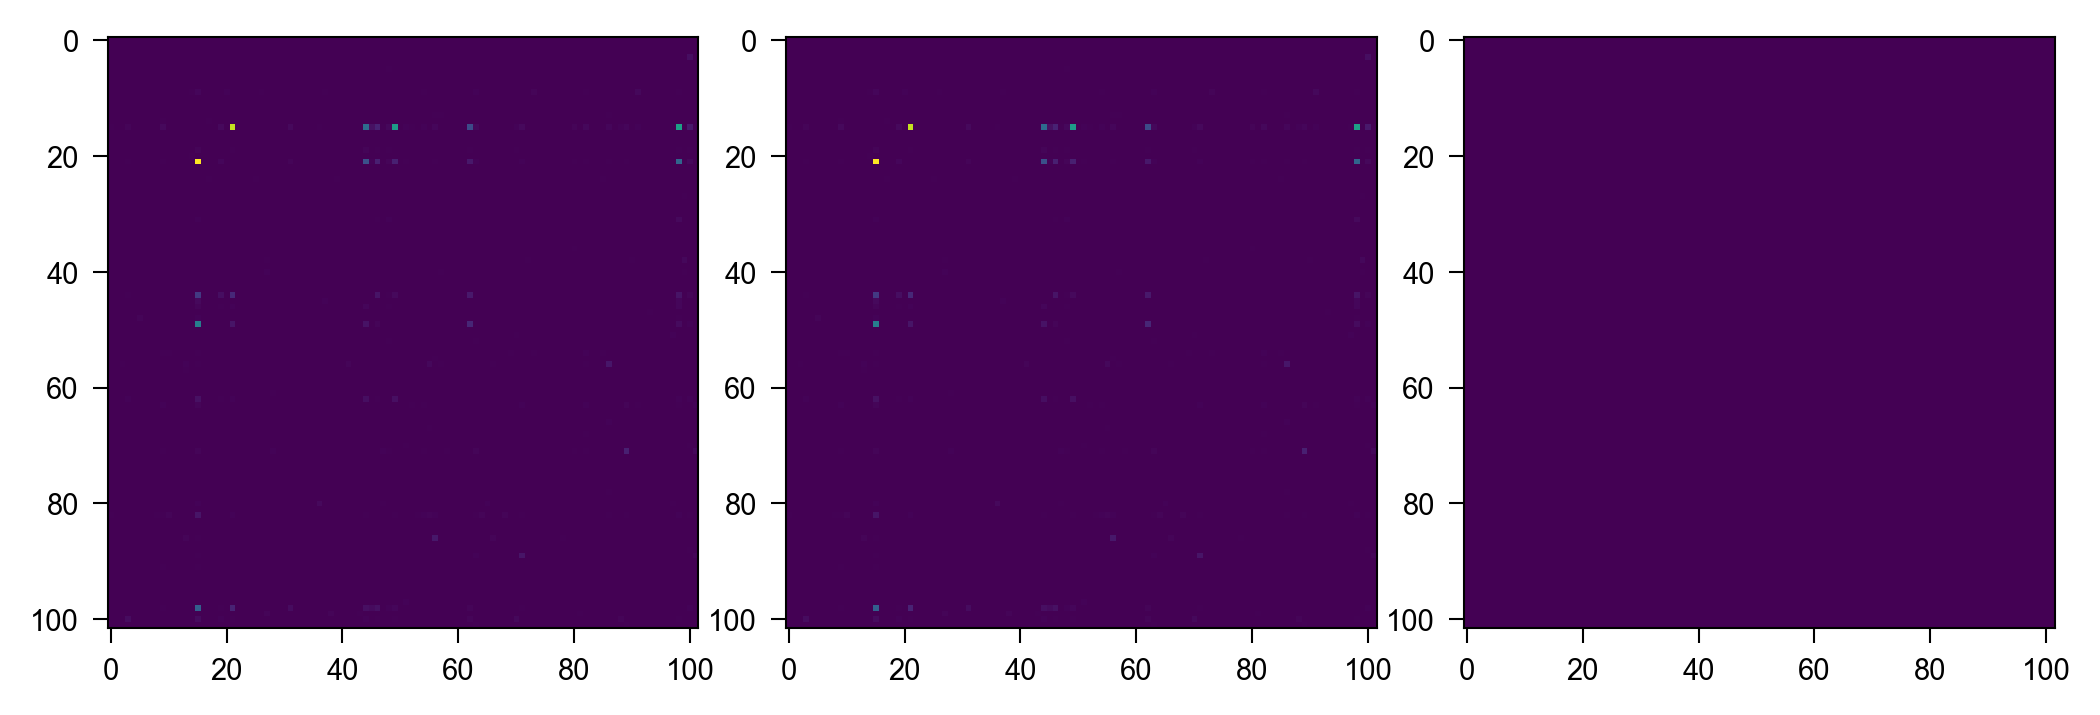

In [19]:
D = 20
df_sparse = df.copy()
df_sparse.sort_values('flow', ascending=False, inplace=True)
df_sparse = df_sparse[:D*len(node)]
df_sparse

from ND2.utils import get_fig
from matplotlib.colors import LogNorm, Normalize
fi, fig, axes = get_fig(1, 3, AW=5)
norm = Normalize(vmin=0, vmax=df['flow'].max())
pivot1 = df.pivot_table(index='source', columns='destination', values='flow', fill_value=0, aggfunc='sum').reindex(index=node, columns=node, fill_value=0)
pivot2 = df_sparse.pivot_table(index='source', columns='destination', values='flow', fill_value=0, aggfunc='sum').reindex(index=node, columns=node, fill_value=0)
axes[0].imshow(pivot1.values, norm=norm)
axes[1].imshow(pivot2.values, norm=norm)
axes[2].imshow(pivot1.values - pivot2.values, norm=norm)
plt.show()

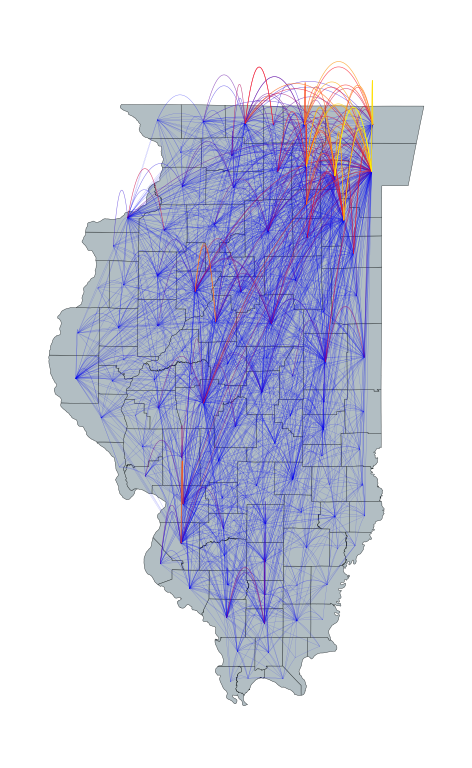

In [20]:
import geopandas as gpd
from ND2.utils.plot import get_fig, plotOD
from shapely.ops import unary_union

data = df_sparse
data.columns = ['source', 'destination', 'flow']
save_and_cache('https://www2.census.gov/geo/tiger/TIGER2016/COUSUB/tl_2016_17_cousub.zip',
                '../data/epidemic/tl_2016_17_cousub.zip')
gdf = gpd.read_file('../data/epidemic/tl_2016_17_cousub.zip')

tmp = []
for (state_fp, county_fp), group in gdf.groupby(['STATEFP', 'COUNTYFP']):
    name = GEOID2Name[int(state_fp + county_fp)]
    polygon = unary_union(group['geometry'])
    tmp.append((name, polygon))
gdf = gpd.GeoDataFrame(tmp, columns=['NAME', 'geometry'], crs=gdf.crs)

fi, fig, axes = get_fig(1, 1, AW=3*2, A_ratio=1, LM=0, RM=0, BM=0, TM=0.0, lw=1.0, fontsize=14)
gdf.plot(ax=axes[0], color='#b2bec3', edgecolor='#2d3436', linewidth=0.1)
location = {row['NAME']: row['geometry'].centroid.coords[0] for _, row in gdf.iterrows()}
plotOD(axes[0], data['source'], data['destination'], data['flow'], location, linetype='parabola')
axes[0].axis('off')
fig.savefig('../plot/epidemic/ODinILS.png', dpi=600, transparent=True)
fig.savefig('../plot/epidemic/ODinILS.svg', transparent=True)

Drawing Boundaries: 100%|██████████| 102/102 [00:00<00:00, 789.70it/s]


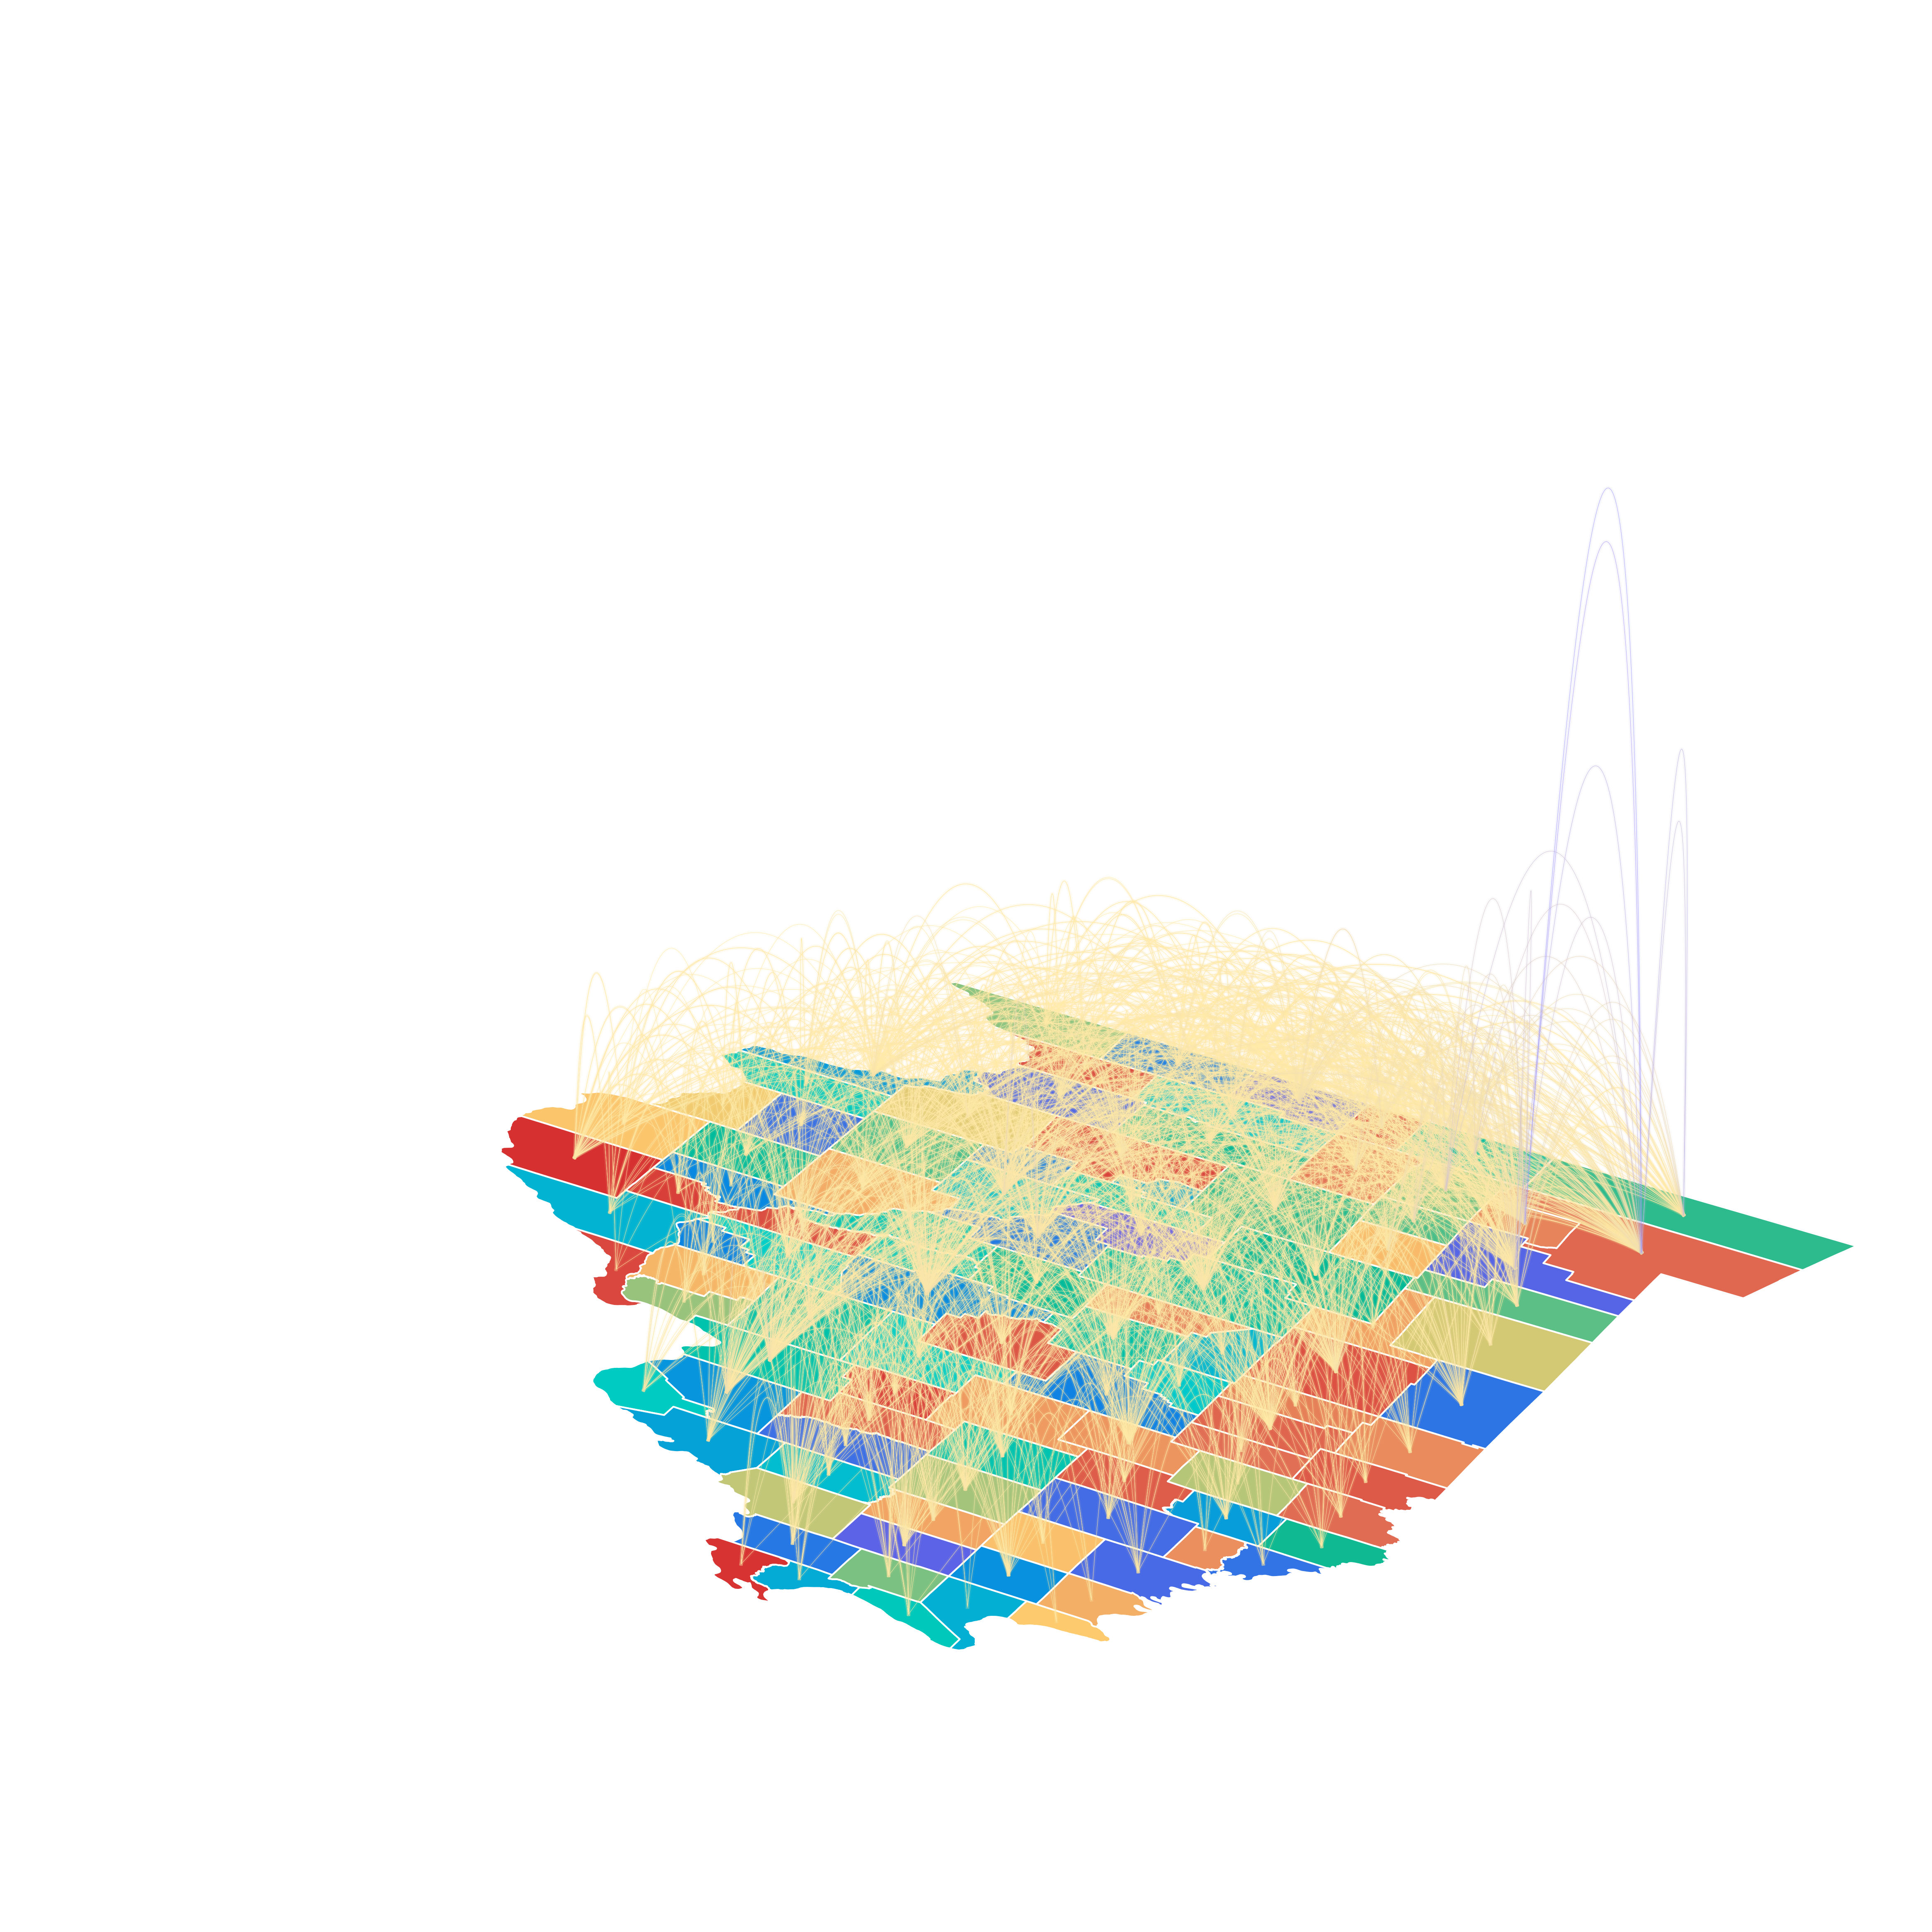

In [21]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.colors import LinearSegmentedColormap, Normalize
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

data = df_sparse
data.columns = ['source', 'destination', 'flow']

fig = plt.figure(figsize=(12, 8), dpi=600)
ax = fig.add_subplot(111, projection='3d')

# 绘制 OD 线路
center_dict = {row['NAME']:row['geometry'].centroid.coords[0] for _, row in gdf.iterrows()}
myhot = LinearSegmentedColormap.from_list('myhot', ['#ffeaa7', '#a29bfe'], gamma=0.6)
norm = Normalize(vmin=0, vmax=data['flow'].max())
for idx, row in tqdm(data.iterrows(), total=len(data), desc='Drawing OD Flow'):
    if row['source'] not in center_dict or row['destination'] not in center_dict: 
        print(row['source'], row['destination'])
        continue
    x1, y1 = center_dict[row['source']]
    x2, y2 = center_dict[row['destination']]
    height = 0.1 * (row['flow'] + 0.3 * data['flow'].max())  # 根据流量设置高度，可以调整比例
    t = np.linspace(0, 1, num=100)
    x = x1 + (x2 - x1) * t
    y = y1 + (y2 - y1) * t
    z = height * 4 * t * (1 - t)  # 抛物线方程
    ax.plot(x, y, z, color=myhot(norm(row['flow'])), linewidth=1.0, zorder=10000+row['flow'], alpha=0.08)
    ax.plot(x, y, z, color=myhot(norm(row['flow'])), linewidth=0.1, zorder=10000+row['flow'], alpha=1.0)

ax.set_xlim(*ax.get_xlim()) # fix aspect ratio
ax.set_ylim(*ax.get_ylim())

# 绘制区域
myhsv = LinearSegmentedColormap.from_list('myhsv', ['#d63031', '#e17055', '#fdcb6e', '#00b894', '#00cec9', '#0984e3', '#6c5ce7'])
norm = Normalize(vmin=0, vmax=len(gdf))
for idx, row in tqdm(gdf.iterrows(), total=len(gdf), desc='Drawing Boundaries'):
    if row['geometry'].geom_type == 'Polygon':
        x, y = row['geometry'].exterior.xy
        poly_collection = Poly3DCollection([list(zip(x, y, [0]*len(x)))], color=myhsv(norm(idx)), zorder=10, linewidth=0.5, edgecolor='white')
        ax.add_collection3d(poly_collection)
    elif row['geometry'].geom_type == 'MultiPolygon':
        for polygon in row['geometry'].geoms:
            x, y = polygon.exterior.xy
            poly_collection = Poly3DCollection([list(zip(x, y, [0]*len(x)))], color=myhsv(norm(idx)), zorder=10, linewidth=0.5, edgecolor='white')
            ax.add_collection3d(poly_collection)

# 设置视角和标签
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
# ax.set_title('OD Flow')
ax.axis('off')

# X = np.linspace(*ax.get_xlim(), 10)
# Y = np.linspace(*ax.get_ylim(), 10)
# X, Y = np.meshgrid(X, Y)
# Z = np.zeros_like(X)
# ax.plot_surface(X, Y, Z, zorder=0, color='#000034', alpha=0.1)

# ax.set_facecolor('lightblue')
fig.tight_layout()

plt.show()

# 保存数据

In [22]:
import json

node2idx = {n:idx for idx, n in enumerate(node)}
df_sparse['source_idx'] = df_sparse['source'].map(node2idx)
df_sparse['destination_idx'] = df_sparse['destination'].map(node2idx)
G = df_sparse[['source_idx', 'destination_idx']].values
A = np.zeros((len(node), len(node),), dtype=int)
A[G[:, 0], G[:, 1]] = 1

save = {}
save['node'] = node.tolist() # (N=62,)
save['time'] = time.tolist() # (T=1142,)
save['case'] = case.tolist() # (T=1142, N=62)
save['flow'] = df_sparse['flow'].tolist() # (E=1240,)
save['A'] = A.tolist() # (N=62, N=62)
save['G'] = G.tolist() # (E=1240, 2)
with open('../data/epidemic/COVID19inILS.json', 'w') as f:
    json.dump(save, f)

for key, value in save.items():
    print(f'{key:10} -> {np.array(value).shape}')

node       -> (102,)
time       -> (163,)
case       -> (163, 102)
flow       -> (2040,)
A          -> (102, 102)
G          -> (2040, 2)
